In [2]:
import numpy as np
import pandas as pd
import csv
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
%matplotlib inline

Set locations

In [3]:
DATA_LOCATION = '../data/'
TEST_IMAGES_LOCATION = '../data/test_images/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'

# Import data

### Label mapping

In [4]:
label_map = pd.read_csv(DATA_LOCATION + 'label_map.txt', sep=' ', names=['class_name','class_nr'])

In [5]:
label_map.sample(n=10)

,class_name,class_nr
7,acantharia_protist_halo,7
34,appendicularian_s_shape,34
42,radiolarian_chain,42
40,fish_larvae_medium_body,40
79,pteropod_theco_dev_seq,79
29,crustacean_other,29
4,hydromedusae_solmundella,4
8,trichodesmium_tuft,8
90,trochophore_larvae,90
54,amphipods,54


### Sample data

In [6]:
sample = pd.read_csv(DATA_LOCATION + 'sample.csv', names=['image','class_nr'], header=0)

In [7]:
sample.sample(n=10)

,image,class_nr
956,54577.jpg,0
4169,94669.jpg,0
3948,3186.jpg,0
1927,30315.jpg,0
2161,95138.jpg,0
4924,74662.jpg,0
5187,104126.jpg,0
5793,41287.jpg,0
6105,115273.jpg,0
2178,105616.jpg,0


### Train data

In [8]:
train_labels = pd.read_csv(DATA_LOCATION + 'train_onelabel.csv')

In [9]:
train_labels.sample(n=10)

,image,class
19181,132977.jpg,99
15360,80565.jpg,70
12683,30543.jpg,58
20873,57330.jpg,101
4373,27110.jpg,20
22898,67832.jpg,113
212,95091.jpg,0
1707,83575.jpg,6
6887,87793.jpg,29
11724,92.jpg,56


In [11]:
with open(DATA_LOCATION + 'train_onelabel.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_counts = {}
    for row in reader:
        if(row[1] != 'class'):
            class_counts[int(row[1])] = class_counts.get(int(row[1]), 0) + 1
    max_nr = max(class_counts.values())
    for key, value in class_counts.items():
        class_counts[key] = int(class_counts[key] + (max_nr - class_counts[key])/6)

print(sorted(list(class_counts.values())))
print(counts)

[269, 269, 269, 270, 270, 270, 271, 272, 272, 274, 274, 275, 276, 278, 278, 279, 280, 280, 281, 282, 282, 282, 283, 285, 285, 287, 287, 289, 290, 291, 295, 296, 296, 299, 299, 300, 300, 300, 301, 301, 305, 305, 306, 311, 312, 314, 315, 317, 317, 319, 321, 321, 321, 325, 325, 328, 331, 335, 338, 339, 341, 343, 345, 345, 349, 350, 355, 357, 361, 362, 363, 364, 376, 377, 380, 384, 384, 385, 386, 401, 402, 412, 412, 421, 421, 449, 457, 457, 483, 485, 489, 502, 509, 520, 525, 531, 533, 544, 545, 557, 577, 590, 593, 605, 617, 620, 676, 715, 722, 728, 730, 739, 740, 800, 849, 854, 870, 1050, 1067, 1559, 1580]
[7, 7, 7, 9, 9, 9, 10, 11, 11, 13, 13, 15, 16, 18, 18, 19, 20, 20, 22, 23, 23, 23, 24, 26, 27, 29, 29, 31, 32, 34, 38, 40, 40, 43, 43, 44, 44, 45, 46, 46, 50, 50, 52, 58, 59, 61, 63, 65, 65, 67, 70, 70, 70, 74, 75, 78, 82, 87, 90, 91, 94, 96, 99, 99, 103, 104, 110, 113, 118, 119, 120, 121, 136, 137, 140, 145, 145, 146, 148, 166, 167, 179, 179, 190, 190, 223, 233, 233, 264, 267, 271, 287,

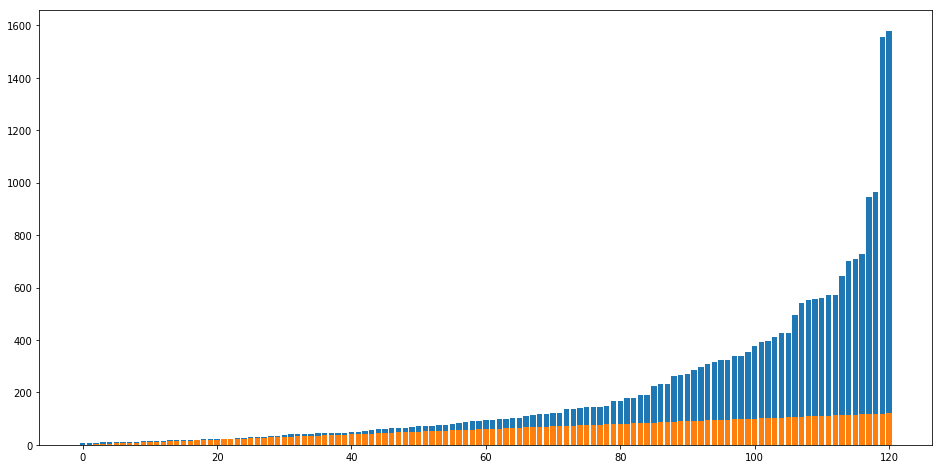

In [12]:
counts = train_labels.groupby('class').count().astype('int').sort_values('image')['image'].values.tolist()
plt.figure(figsize=(16,8))
plt.bar(range(len(counts)), counts)
plt.bar(range(len(counts)), sorted(list(class_counts)))
plt.show()

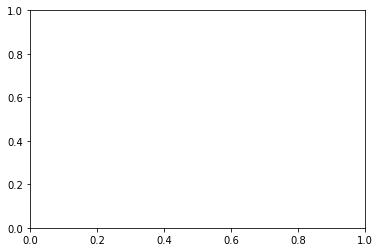

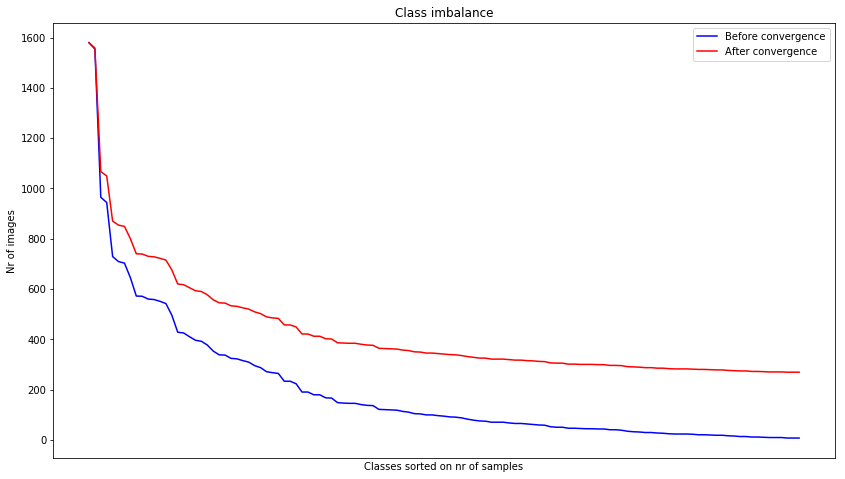

In [16]:

fig, ax = plt.subplots()
plt.figure(figsize=(14,8))
index = np.arange(121)

rects1 = plt.plot(sorted(counts,reverse=True),
                 color='b',
                 label='Before convergence')

rects2 = plt.plot(sorted(list(class_counts.values()),reverse=True),
                 color='r',
                 label='After convergence')

plt.xlabel('Classes sorted on nr of samples')
plt.ylabel('Nr of images')
plt.title('Class imbalance')
plt.legend()
plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off')

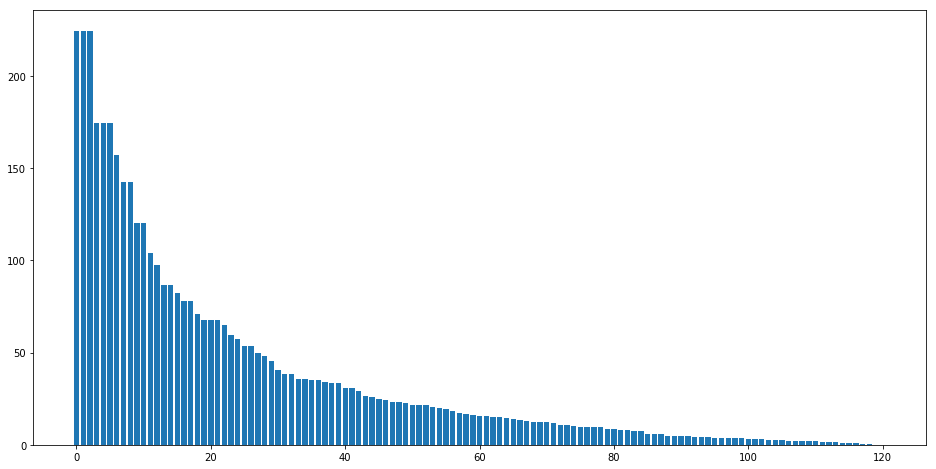

In [17]:
# the number of times the images in a class need to be added in order to balance items per class
times = []
for count in counts:
    times.append((1580 - count)/count)
plt.figure(figsize=(16,8))
plt.bar(range(len(times)), times)
plt.show()

In [18]:
with open(DATA_LOCATION + 'train_onelabel.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_counts = {}
    for row in reader:
        if(row[1] != 'class'):
            class_counts[int(row[1])] = class_counts.get(int(row[1]), 0) + 1
    # mean == 200
    mean = int(sum(class_counts.values()) / len(class_counts))
    max_nr = max(class_counts.values())
    for key, value in class_counts.items():
        class_counts[key] = int(class_counts[key] + (max_nr - class_counts[key])/3)

print(sum(class_counts.values()))

79829


## The actual images

Show a random image from the training set

In [19]:
def get_image(filepath):
    """
    Load image from filepath to a numpy.ndarray
    input:
        - filepath: string with relative or absolute path to image
    output:
        - img:
            numpy.ndarray containing the image
            shaped (M,N), values [0.0, 1.0]
    """
    try:
        img = TRAIN_IMAGES_LOCATION + filepath
        img = mpimg.imread(img)
    except:
        img = filepath
        img = mpimg.imread(img)
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    return img

def show_image(filepath):
    """
    Show the image through Matplotlib
    input:
        - filepath: string with relative or absolute path to image
    output:
        - None
    """
    img = get_image(filepath)
    plt.imshow(img,cmap='binary')

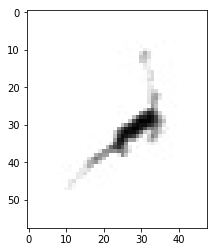

In [20]:
# show a random image from the train set
show_image(train_labels.sample(n=1).iloc[0]['image'])

## Making images square and resizing to consistent shape

In [21]:
def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))

    
def pad_image(image_path):
    """
    Add padding to image to make it square
    input:
        - image_path: string path of image
    output:
        - padded array of shape (N,N)
    """
    H, W = get_image(image_path).shape
    array = get_image(image_path)
    if H == W:
        return array
    elif H > W:
        return np.pad(array, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(array, (get_padding(W-H), (0,0)), 'constant')
    
def resize_image(img, size):
    """
    Resize image to new square shape
    input:
        - img: numpy array representing image
        - size: final shape of image in pixels (integer)"""
    return resize(img, (size,size), mode='reflect')

In [22]:
# Small sample
squares = [pad_image(TRAIN_IMAGES_LOCATION+train_labels.iloc[i]['image']) for i in range(100)]

In [23]:
def show(array):
    plt.imshow(array,cmap='binary')

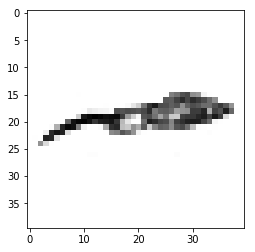

In [24]:
show(resize_image(squares[11], 40))

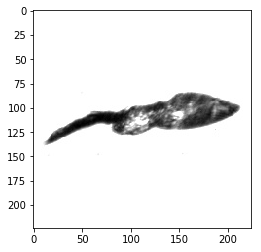

In [25]:
show(squares[11])